# PCA + Neural Network Classifier with MNIST


## Libraries

In [1]:
# libraries
#using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
#using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

function batchImage2DF(imagesArray3D)
    vectorOfImageVectors = batchImage2Vector(imagesArray3D)
    M = reduce(hcat, vectorOfImageVectors)
    DataFrame(M', :auto)
end


batchImage2DF (generic function with 1 method)

In [3]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Loading the data

,,,,

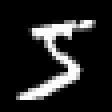
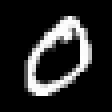
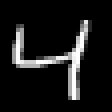
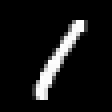
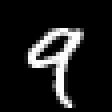

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [5]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Data preprocessing depends on the data source, thus can widely vary from what is shown here.

In [6]:
function preprocessing(X, y)
    newX = batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X, y = preprocessing(trainX, trainY);

In [7]:
scitype(X)

Table{AbstractVector{Continuous}}

In [8]:
scitype(y)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

## Training, Testing, Validation

### Load and pipe algorithms

In [9]:
# reduce predictors
PCA = @load PCA pkg=MultivariateStats verbosity=0
reducer = PCA(pratio = 0.95)

PCA(
    maxoutdim = 0,
    method = :auto,
    pratio = 0.95,
    mean = nothing)

In [10]:
# standardize predictors
std = Standardizer();

In [11]:
# nnet
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux verbosity=0
nnet = NeuralNetworkClassifier(acceleration=CUDALibs())

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    rng = Random._GLOBAL_RNG(),
    optimiser_changes_trigger_retraining = false,
    acceleration = CUDALibs{Nothing}(nothing))

In [12]:
pipe = @pipeline reducer std nnet

Pipeline294(
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.95,
            mean = nothing),
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    neural_network_classifier = NeuralNetworkClassifier(
            builder = Short,
            finaliser = NNlib.softmax,
            optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()),
            loss = Flux.Losses.crossentropy,
            epochs = 10,
            batch_size = 1,
            lambda = 0.0,
            alpha = 0.0,
            rng = Random._GLOBAL_RNG(),
            optimiser_changes_trigger_retraining = false,
            acceleration = CUDALibs{Nothing}(nothing)))

### Create and train the machine


In [13]:
pipe.neural_network_classifier.epochs = 1   # = 1 for debug, default = 10
mach = MLJ.machine(pipe, X, y) |> fit!


┌ Info: Training Machine{Pipeline294,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{PCA,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464


Machine{Pipeline294,…} trained 1 time; caches data
  model: Pipeline294
  args: 
    1:	Source @691 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @099 ⏎ `AbstractVector{OrderedFactor{10}}`


In [14]:
# save model
MLJ.save("new-model-1-epochs.jlso", mach)


In [15]:
# inspect model
fp = fitted_params(mach);
rp = report(mach);

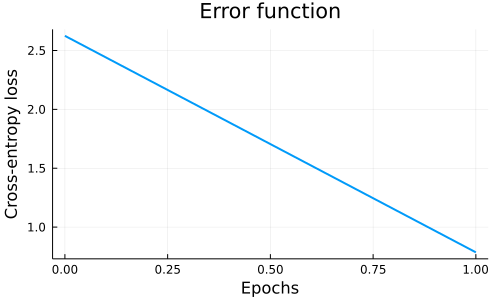

In [16]:
losses = rp.neural_network_classifier.training_losses
epochs = pipe.neural_network_classifier.epochs
plot(0:epochs, losses, title="Error function", size=(500,300), linewidth=2, legend=false)
xlabel!("Epochs")
ylabel!("Cross-entropy loss")

### Predict

In [17]:
ŷ = predict_mode(mach, X)
printMetrics(ŷ, y)

10×10 Matrix{Int64}:
 4004     1    26    13     8    55    25    20    24    23
    0  4604    37    22    15    15    15    29    96     7
   27    21  3763   118    38    28    32    53    84     9
    8    20    67  3844     0   154     0    12   137    52
    6     4    41     7  3823    34    17    42    30   231
   51    17    14   144     6  3312    61     2   166    15
   24     4    71    11    45    67  3975     5    32     3
    8    15    61    57    18    26     3  4143    22   235
   16    27    79    41    15    58    13     7  3430    23
    2     6    12    35   121    46     2    73    75  3566

accuracy: 0.916
f1-score: 0.914


### Tuning

Single parameter (lambda)

Remark: > 2h execution on a gamers computer

In [28]:
?learning_curve!

search: learning_curve! learning_curve



No documentation found.

`MLJTuning.learning_curve!` is a `Function`.

```
# 1 method for generic function "learning_curve!":
[1] learning_curve!(mach::Machine{var"#s87", C} where {var"#s87"<:Supervised, C}; kwargs...) in MLJTuning at /home/ciro/.julia/packages/MLJTuning/Al9yX/src/learning_curves.jl:96
```


In [36]:
r = range(pipe, :(neural_network_classifier.lambda), lower = 1e-3, upper=1e-2, scale=:log10)

_, _, lambdas, losses = learning_curve(mach,
                                       range=r,
                                       resampling=CV(nfolds=3),
                                       resolution=5, # default = 30
                                       # acceleration=CPUProcesses() or acceleration=CPUThreads(),
                                       measure=cross_entropy)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning /home/ciro/.julia/packages/MLJTuning/Al9yX/src/tuned_models.jl:680
Evaluating over 5 metamodels: 100%[=========================] Time: 0:50:15


(parameter_name = "neural_network_classifier.lambda",
 parameter_scale = :log10,
 parameter_values = [0.001, 0.0017782794100389228, 0.0031622776601683794, 0.005623413251903491, 0.01],
 measurements = [0.41041588178599503, 0.48238112501399444, 0.6024657185375627, 0.8028990583020618, 1.1582995940602745],)

Best lambda: 0.001


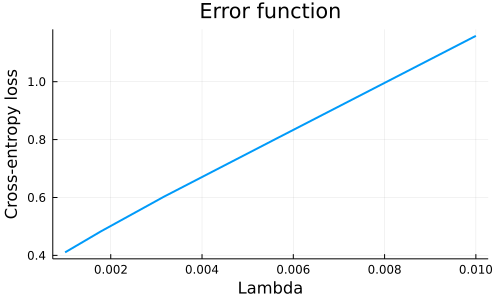

In [37]:
best_lambda = lambdas[argmin(losses)]
println("Best lambda: ", best_lambda)

plot(lambdas, losses, title="Error function", size=(500,300), linewidth=2, legend=false)
xlabel!("Lambda")
ylabel!("Cross-entropy loss")


In [38]:
# update the machine with the best parameter
pipe.neural_network_classifier.lambda = best_lambda
fit!(mach)
MLJ.save("new-model-2-lambdas.jlso", mach)

ŷ = predict_mode(mach, X)
printMetrics(ŷ, y)

┌ Info: Training Machine{Pipeline294,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{PCA,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464


10×10 Matrix{Int64}:
 4009     2    24    12     3    56    25    17    22    24
    0  4570    27    26    14    12    15    35    99    12
   22    30  3774   109    34    42    33    42    53    15
    9    16    68  3793     0    99     1    14    99    49
   10     5    53     8  3814    35    33    34    38   169
   41    25    17   171     8  3332    57     6   121    28
   34     1    62    17    45    62  3953     3    29     5
    7    12    48    52     7    26     1  4128    10   138
   13    55    93    68    20    88    25    13  3566    28
    1     3     5    36   144    43     0    94    59  3696

accuracy: 0.92
f1-score: 0.919


### Self tuning

Multiple parameters

Remark: > xxxh execution on a gamers computer
